# Fitting of Heisenberg parameters using pyiron

In this notebook, I explain how to find the Heisenberg parameters for bcc Fe up to the second shell. It has the following two (obvious) steps:

1. Launch DFT calculations with ferromagnetic and anti-ferromagnetic states
2. Fit the Heisenberg parameters using Linear Regression

Note:

Although this notebook presents a complete workflow, several points require more detailed analysis. Refer to the conclusion section for further information.

In [1]:
from pyiron_atomistics import Project
import numpy as np
import matplotlib.pylab as plt
from tqdm.auto import tqdm
%matplotlib inline

In [2]:
pr = Project("FIT")

In [3]:
bulk = pr.create.structure.bulk("Fe", cubic=True, a=2.83)

## Creation of dataset

In this notebook, we are going to create three types of magnetic structures: ferromagnetic, anti-ferromagnetic and double-layer anti-ferromagnetic structures. These structures deliver different energy values, and therefore would allow us to fit different $J_{ij}$ values

### First case: ferromagnetic

In [4]:
spx_f = pr.create.job.Sphinx("ferro")
spx_f.structure = bulk.copy()
spx_f.structure.set_initial_magnetic_moments(len(bulk) * [2])
spx_f.set_encut(500)
spx_f.set_kpoints(k_mesh_spacing=0.15)
spx_f.run()

/home/jovyan/dev/pyiron_base/pyiron_base/interfaces/lockable.py:59: LockedWarning: __setitem__ called on <class 'pyiron_atomistics.sphinx.input_writer.Group'>, but object is locked!
  warnings.warn(
/home/jovyan/dev/pyiron_base/pyiron_base/interfaces/lockable.py:59: LockedWarning: __setattr__ called on <class 'pyiron_atomistics.sphinx.input_writer.Group'>, but object is locked!
  warnings.warn(
2024-06-14 06:46:44,514 - pyiron_log - WARNING - The job ferro is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
/home/jovyan/dev/pyiron_base/pyiron_base/interfaces/lockable.py:97: UserWarning: Unlock previously locked object!
  self.owner.read_only = False
/home/jovyan/dev/pyiron_base/pyiron_base/interfaces/lockable.py:320: UserWarning: Unlock previously locked object!
  it.read_only = False


### Second case: anti-ferromagnetic

In [5]:
spx_af = pr.create.job.Sphinx("antiferro")
spx_af.structure = bulk.copy()
layers = spx_af.structure.analyse.get_layers(planes=[0, 0, 1])
spx_af.structure.set_initial_magnetic_moments(2 - 4 * (layers % 2 == 1))
spx_af.set_encut(500)
spx_af.set_kpoints(k_mesh_spacing=0.15)
spx_af.run()

/home/jovyan/dev/pyiron_base/pyiron_base/interfaces/lockable.py:59: LockedWarning: __setitem__ called on <class 'pyiron_atomistics.sphinx.input_writer.Group'>, but object is locked!
  warnings.warn(
/home/jovyan/dev/pyiron_base/pyiron_base/interfaces/lockable.py:59: LockedWarning: __setattr__ called on <class 'pyiron_atomistics.sphinx.input_writer.Group'>, but object is locked!
  warnings.warn(
2024-06-14 06:46:50,358 - pyiron_log - WARNING - The job antiferro is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
/home/jovyan/dev/pyiron_base/pyiron_base/interfaces/lockable.py:97: UserWarning: Unlock previously locked object!
  self.owner.read_only = False
/home/jovyan/dev/pyiron_base/pyiron_base/interfaces/lockable.py:320: UserWarning: Unlock previously locked object!
  it.read_only = False


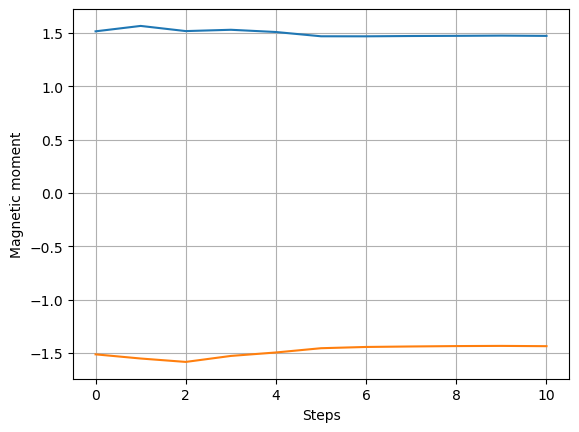

In [6]:
# Make sure that the magnetic moments were stable

plt.xlabel("Steps")
plt.ylabel("Magnetic moment")
plt.grid()
plt.plot(spx_af.output.generic.dft.atom_scf_spins[0]);

### Last case: Non-magnetic

Let's take also a non-magnetic one into account

In [7]:
spx_n = pr.create.job.Sphinx("nonmag")
spx_n.structure = bulk.copy()
spx_n.set_encut(500)
spx_n.set_kpoints(k_mesh_spacing=0.15)
spx_n.run()

2024-06-14 06:46:55,008 - pyiron_log - WARNING - The job nonmag is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


## Evaluation of results

In the following, we are going to obtain the $J_{ij}$ parameters by fitting the DFT results to our model. First, let's come back to the Heisenberg model:

$$\mathcal H = -\frac{1}{2}\sum_{ij} J_{ij}m_im_j$$

This equation can be rewritten as:

$$\mathcal H = -\frac{1}{2}\sum_s J_s\sum_{ij} D_{s,ij}m_im_j$$

where $J_s$ is the Heisenberg parameter for the shell $s$ and the shell matrix $D_{s,ij}$ is defined as:

\begin{align}
D_{s,ij} =
\begin{cases}
1 & \text{if $i$ and $j$ are neighbors of shell $s$}\\
0 & \text{else}
\end{cases}
\end{align}

$D_{s,ij}$ can be obtained from `get_shell_matrix` in the `Neighbors` class in pyiron. It returns all the shell matrices in a list.

In [8]:
class EvaluateJob:
    def __init__(self, job, n_shells=1):
        self.ref_job = job
        self.n_shells = n_shells

    @property
    def _neighbors(self):
        return self.ref_job.structure.get_neighbors(
            num_neighbors=100
        )
    
    @property
    def _shell_matrices(self):
        return self._neighbors.get_shell_matrix()[:self.n_shells]

    @property
    def _magmoms(self):
        if "atom_spins" in job["output/generic/dft"]:
            return self.ref_job.output.generic.dft.atom_spins[-1]
        else:
            return np.array(len(self.ref_job.structure) * [0])
    
    @property
    def values(self):
        m = self._magmoms
        # len(m) is required to intercept the per-atom energy
        J = [-mat.dot(m).dot(m) / 2 for mat in self._shell_matrices]
        A = [np.sum(m**ii) for ii in [2, 4, 6]]
        return np.array(J + A)

    @property
    def derivatives(self):
        m = self._magmoms
        dJ = [-ss.dot(m) for ss in self._shell_matrices]
        dA = [ii * m**(ii - 1) for ii in [2, 4, 6]]
        return np.array(dJ + dA).T

In [9]:
job_nonmag = pr.load("nonmag")

E_nonmag = job_nonmag["output/generic/energy_pot"][-1] / len(job_nonmag.structure)

x_lst, y_lst = [], []
for job in pr.iter_jobs(job="^(?!nonmag$)", mode="regex"):
    ej = EvaluateJob(job)
    x_lst.append(ej.values / len(job.structure))
    y_lst.append(job["output/generic/energy_pot"][-1] / len(job.structure) - E_nonmag)
    x_lst.append(ej.derivatives[0])
    y_lst.append(0)

  0%|          | 0/2 [00:00<?, ?it/s]

/home/jovyan/dev/pyiron_base/pyiron_base/interfaces/lockable.py:59: LockedWarning: __setitem__ called on <class 'pyiron_atomistics.sphinx.input_writer.Group'>, but object is locked!
  warnings.warn(


In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
reg = LinearRegression(fit_intercept=False).fit(x_lst, y_lst)

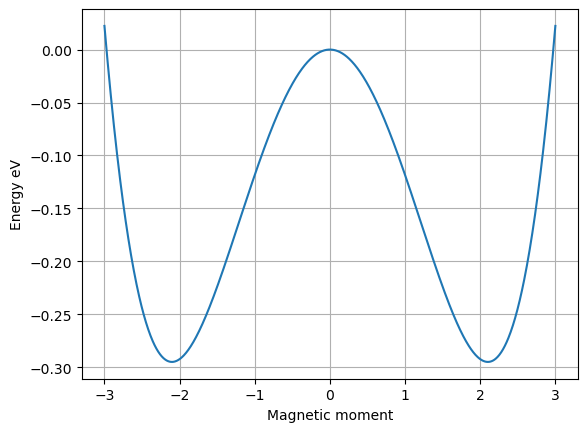

In [12]:
m = np.linspace(-3, 3, 1000)
plt.ylabel("Energy eV")
plt.xlabel("Magnetic moment")
plt.grid()
plt.plot(m, reg.coef_[1] * m**2 + reg.coef_[2] * m**4);

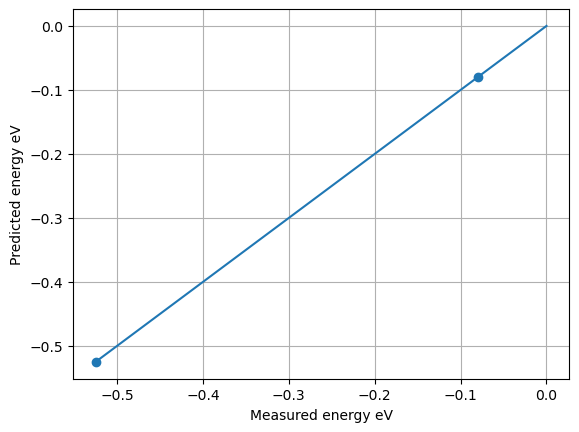

In [13]:
plt.ylabel("Predicted energy eV")
plt.xlabel("Measured energy eV")
plt.grid()
plt.plot(*2 * [[min(y_lst[::2]), 0]])
plt.scatter(y_lst[::2], np.einsum("ni,i->n", x_lst, reg.coef_)[::2]);

## Monte Carlo simulation for the magnetization curve

In [14]:
from mamonca import MC

In [15]:
large_structure = bulk.repeat(20)

In [16]:
# 14 neighbors, so that the first shell (8 atoms) and second shell (6 atoms) would be included.
neigh = large_structure.get_neighbors(num_neighbors=14)

mc = MC(len(large_structure))
for ss, J in zip(neigh.get_shell_matrix()[:1], reg.coef_[:1]):
    mc.set_heisenberg_coeff(J * ss)

mc.set_landau_coeff(reg.coef_[1], 2)
mc.set_landau_coeff(reg.coef_[2], 4)
# mc.set_landau_coeff(reg.coef_[3], 6)

In [17]:
temperatures = np.arange(100, 2000, 100)

magnetization_lst = []
for T in tqdm(temperatures):
    mc.run(T, 20000)
    magnetization_lst.append(mc.get_magnetization()[-1])


  0%|          | 0/19 [00:00<?, ?it/s]

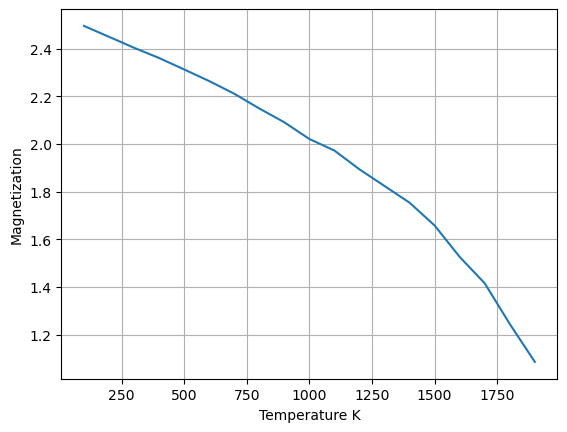

In [18]:
plt.xlabel("Temperature K")
plt.ylabel("Magnetization")
plt.grid()
plt.plot(temperatures, magnetization_lst);

As you can see in the figure above, the transition temperature is fairly different from the experimental Curie temperature (~1,000 K). But I list a few items that probably have played a role, with varying effects.

- Only the first shell was considered
- Data set consisted of only 3 points
- Temperature effects (vibration, thermal expansion) not included

Probably by properly taking care of the first three points, we can achive much better results.

# Discussion

In this notebook, I created small boxes with simple magnetic states, but obviously we can also include more complex magnetic states. With the evaluation class that I wrote above, all the $J_{ij}$ parameters would be properly taken into account. Furthermore, it might be also interesting to think about including longitudinal components. There are already some extended models that can do it. Also in the next step, we should also try to take chemical species in consideration. The functionality is already included in the `Neighbors` class.

The fitting was done using linear regression here. If the number of descriptors grows, it might be interesting to look into other regression schemes.